# **Sentiment Analysis on Tweets**
Sentiment analysis, also known as opinion mining, is the process of identifying and categorizing emotions expressed in text data—typically as positive, negative, or neutral. It helps organizations and individuals understand the sentiment behind user-generated content, such as product reviews, social media posts, or customer feedback.

In the context of social media, sentiment analysis is particularly valuable due to the vast amount of real-time user opinions shared daily. Twitter, with its concise and public messages, provides an ideal dataset for analyzing public sentiment around topics, events, brands, or products.

By leveraging natural language processing (NLP) techniques and machine learning models, sentiment analysis can extract insights from tweets to support business decisions, brand monitoring, political analysis, and crisis management.

This project focuses on building a sentiment classifier using a dataset of tweets. The model aims to classify each tweet as positive or negative, helping reveal how people feel about certain topics at scale.

<br>

**Dataset:** [Kaggle Sentiment140](https://www.kaggle.com/datasets/kazanova/sentiment140/data)

---

## **Data Preprocessing**

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import emoji
import re
import nltk
import tensorflow as tf

from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

nltk.download('punkt_tab')
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\Juls\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Juls\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Juls\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Juls\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\Juls\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


Prepare the dataset.

In [17]:
dataset_path = '../data/twt.csv'
column_names = ['sentiment', 'id', 'date', 'flag', 'user', 'text']
df = pd.read_csv(dataset_path, encoding='latin', delimiter=',', names=column_names)
df.head()

,sentiment,id,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


Drop unimportant columns and missing values.

In [18]:
df = df.drop(['id', 'date', 'flag', 'user'], axis=1)
df = df.dropna()
df.head()

,sentiment,text
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."


### Preprocess the data:
- convert the emojis into text
- lowercase everything
- remove urls, mentions and hashtags
- remove punctuations and special characters
- remove stopwords
- split into tokens

In [19]:
print("Sample stopwords being removed:")
print(list(stop_words))

Sample stopwords being removed:
['were', "mustn't", 'doing', 'up', 'y', 'no', "couldn't", 'having', 'before', "didn't", 'then', 'him', "he'll", "i'm", "needn't", 'the', 'which', 'weren', 'am', 'should', 'mightn', 'in', 'myself', 'very', 'below', 'ain', "you're", 'ourselves', 'those', 'couldn', 'between', 'theirs', 'to', "she'd", 'further', 'only', 'won', 'her', 'over', 'by', 't', "weren't", 'your', 'this', 'his', 'own', "shan't", 'aren', 'against', 'will', "i'll", "he's", 'above', "it's", 'themselves', 'through', 'of', 'they', "that'll", 'most', 'few', 'itself', "we're", 'just', 'any', 'but', 'wasn', "you'd", 'so', 'these', "it'd", 'you', 'at', "haven't", 'm', 'and', 'have', 'hers', 'why', 'mustn', 'where', 'don', 'has', 'isn', 'll', 'ours', "shouldn't", 'such', 'd', 'did', 'off', 'what', 'haven', 'about', "they'd", 'we', "you'll", 'nor', 'an', 'being', 'out', 'same', 'under', 'our', "mightn't", 'does', 'was', "they're", 'some', "they'll", 'are', "she'll", 'yourself', 'for', 'o', 'both

In [20]:
sentiment_critical = {
    'not', 'no', 'never', 'nothing', 'nobody', 'none', 'nowhere', 'neither',
    'very', 'really', 'quite', 'rather', 'extremely', 'incredibly', 'absolutely',
    'but', 'however', 'although', 'though', 'yet', 'except',
    'too', 'so', 'such', 'more', 'most', 'less', 'least',
    'only', 'just', 'still', 'even', 'again'
}

negative_contractions = {
    "don't", "won't", "can't", "shouldn't", "wouldn't", "couldn't",
    "isn't", "aren't", "wasn't", "weren't", "hasn't", "haven't",
    "hadn't", "doesn't", "didn't", "won't", "shan't", "mustn't",
    "mightn't", "needn't"
}

sentiment_critical.update(negative_contractions)

In [21]:
def clean_twts(twt):
    twt = twt.lower()
    twt = re.sub(r"http\S+|www\S+|https\S+", '', twt)  # remove urls
    twt = re.sub(r"@\w+", '', twt)  # remove mentions
    twt = re.sub(r"#", '', twt)  # remove hashtag symbol
    twt = emoji.replace_emoji(twt, replace='')  # remove emojis
    twt = re.sub(r"[^a-zA-Z\s']", '', twt)  # remove punctuation
    twt = re.sub(r"\s+", ' ', twt).strip()  # clean whitespace

    tokens = twt.split()
    tokens = [word for word in tokens if (word not in stop_words or word in sentiment_critical) and len(word) > 1] # remove stopwords and keep sentiment-critical words
    tokens = [lemmatizer.lemmatize(word) for word in tokens]  # lemmatize

    return ' '.join(tokens)

cleaned_twts = df['text'].apply(clean_twts)
df['cleaned_text'] = cleaned_twts

In [22]:
df.head()

,sentiment,text,cleaned_text
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",that's bummer shoulda got david carr third day
1,0,is upset that he can't update his Facebook by ...,upset can't update facebook texting might cry ...
2,0,@Kenichan I dived many times for the ball. Man...,dived many time ball managed save rest go bound
3,0,my whole body feels itchy and like its on fire,whole body feel itchy like fire
4,0,"@nationwideclass no, it's not behaving at all....",no not behaving mad can't see


In [23]:
# Check average tweet length after preprocessing
lengths = [len(text.split()) for text in cleaned_twts]
print(f"Average length: {np.mean(lengths):.2f}")
print(f"95th percentile: {np.percentile(lengths, 95):.2f}")

Average length: 7.42
95th percentile: 15.00


Tokenize the data.

In [24]:
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=10000, oov_token="<OOV>")
tokenizer.fit_on_texts(cleaned_twts)
sequences = tokenizer.texts_to_sequences(cleaned_twts)
padded_sequences = tf.keras.preprocessing.sequence.pad_sequences(sequences, maxlen=20, padding='post', truncating='post')

print("Tokenized and padded sequences:")
print(padded_sequences)

Tokenized and padded sequences:
[[  82 1059 3184 ...    0    0    0]
 [ 641   28  292 ...    0    0    0]
 [   1  222   17 ...    0    0    0]
 ...
 [ 131 7273 6824 ...    0    0    0]
 [  63  205  179 ...    0    0    0]
 [  63    1    0 ...    0    0    0]]


Add into the dataframe.

In [25]:
df['padded_text'] = list(padded_sequences)
df['sentiment'] = df['sentiment'].map({4: 1, 0: 0})
df.head()

,sentiment,text,cleaned_text,padded_text
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",that's bummer shoulda got david carr third day,"[82, 1059, 3184, 18, 735, 8889, 1695, 6, 0, 0,..."
1,0,is upset that he can't update his Facebook by ...,upset can't update facebook texting might cry ...,"[641, 28, 292, 445, 1855, 198, 290, 987, 86, 1..."
2,0,@Kenichan I dived many times for the ball. Man...,dived many time ball managed save rest go bound,"[1, 222, 17, 861, 1480, 747, 368, 10, 2921, 0,..."
3,0,my whole body feels itchy and like its on fire,whole body feel itchy like fire,"[329, 674, 43, 2669, 9, 999, 0, 0, 0, 0, 0, 0,..."
4,0,"@nationwideclass no, it's not behaving at all....",no not behaving mad can't see,"[11, 5, 9422, 487, 28, 27, 0, 0, 0, 0, 0, 0, 0..."


Split the dataset.

In [26]:
x = padded_sequences
y = df['sentiment']


x_train, x_temp, y_train, y_temp = train_test_split(x, y, test_size=0.4, random_state=42)

x_val, x_test, y_val, y_test = train_test_split(x_temp, y_temp, test_size=0.5, random_state=42)

In [27]:
best_params = {
    'lstm_units': 256,
    'dropout_rate': 0.6,
    'dense_units': 128,
    'embedding_dim': 128,
}

model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=10000, output_dim=best_params['embedding_dim']),
    tf.keras.layers.LSTM(best_params['lstm_units'], dropout=best_params['dropout_rate']),
    tf.keras.layers.Dense(best_params['dense_units'], activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [28]:
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model.build(input_shape=(None,20))

In [29]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ (None, 20, 128)        │     1,280,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 256)            │       394,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,707,265 (6.51 MB)

 Trainable params: 1,707,265 (6.51 MB)

 Non-trainable params: 0 (0.00 B)

In [30]:
history = model.fit(
    x_train, y_train,
    epochs=16,
    batch_size=32,
    validation_data=(x_val, y_val)
)

Epoch 1/16
30000/30000 ━━━━━━━━━━━━━━━━━━━━ 994s 33ms/step - accuracy: 0.7683 - loss: 0.4796 - val_accuracy: 0.8045 - val_loss: 0.4220
Epoch 2/16
30000/30000 ━━━━━━━━━━━━━━━━━━━━ 1005s 34ms/step - accuracy: 0.8073 - loss: 0.4180 - val_accuracy: 0.8098 - val_loss: 0.4121
Epoch 3/16
30000/30000 ━━━━━━━━━━━━━━━━━━━━ 1029s 34ms/step - accuracy: 0.8125 - loss: 0.4087 - val_accuracy: 0.8106 - val_loss: 0.4123
Epoch 4/16
30000/30000 ━━━━━━━━━━━━━━━━━━━━ 949s 32ms/step - accuracy: 0.8154 - loss: 0.4036 - val_accuracy: 0.8116 - val_loss: 0.4095
Epoch 5/16
30000/30000 ━━━━━━━━━━━━━━━━━━━━ 865s 29ms/step - accuracy: 0.8174 - loss: 0.4011 - val_accuracy: 0.8111 - val_loss: 0.4109
Epoch 6/16
30000/30000 ━━━━━━━━━━━━━━━━━━━━ 990s 33ms/step - accuracy: 0.8182 - loss: 0.3981 - val_accuracy: 0.8127 - val_loss: 0.4119
Epoch 7/16
30000/30000 ━━━━━━━━━━━━━━━━━━━━ 1074s 36ms/step - accuracy: 0.8198 - loss: 0.3972 - val_accuracy: 0.8118 - val_loss: 0.4140
Epoch 8/16
30000/30000 ━━━━━━━━━━━━━━━━━━━━ 1012s 34

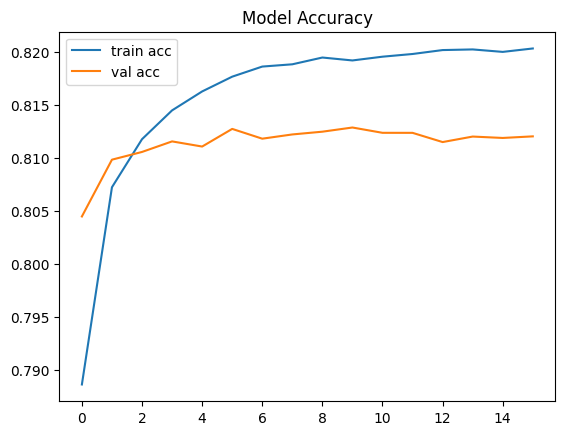

In [31]:
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.legend()
plt.title("Model Accuracy")
plt.show()

In [32]:
preds = model.predict(x_test)
preds_binary = (preds > 0.5).astype(int).flatten()

10000/10000 ━━━━━━━━━━━━━━━━━━━━ 123s 12ms/step


In [33]:
print("Classification Report:")
print(classification_report(y_test, preds_binary))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, preds_binary))

Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.81      0.81    159790
           1       0.81      0.81      0.81    160210

    accuracy                           0.81    320000
   macro avg       0.81      0.81      0.81    320000
weighted avg       0.81      0.81      0.81    320000


Confusion Matrix:
[[129887  29903]
 [ 30509 129701]]


In [34]:
print(f"\nAccuracy: {accuracy_score(y_test, preds_binary):.4f}")
print(f"Precision: {precision_score(y_test, preds_binary):.4f}")
print(f"Recall: {recall_score(y_test, preds_binary):.4f}")
print(f"F1-Score: {f1_score(y_test, preds_binary):.4f}")


Accuracy: 0.8112
Precision: 0.8126
Recall: 0.8096
F1-Score: 0.8111


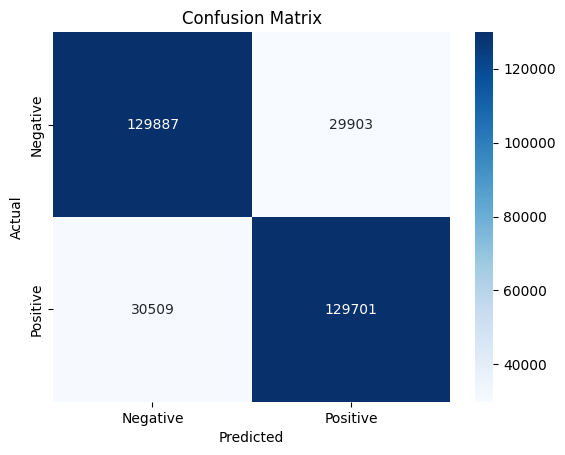

In [35]:
cm = confusion_matrix(y_test, preds_binary)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Negative', 'Positive'],
            yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

---

**Initial training results:** the model can be improved. Will try again.  
**Second attempt:** model improved slightly. Will try again.  
**Third attempt:** tried adding more epochs and batches. Will try again.  
**Fourth attempt:** used lemmatization, better results. Will try again.
**Fifth attempt:** improved stopword removal, model now performing decently. Will try again.  
**Sixth attempt:** hyperparameter tuning using manual randomsearch and cross validation with stratified kfold. Will try to tune again.

---